In [ ]:
import logging as lg
#lg.basicConfig(filename='social_distance.log', encoding = 'utf-8', filemode='w', level=lg.DEBUG, format='%(asctime)s - %(funcName)s - %(lineno)d - %(levelname)s - %(message)s')
file_format1 = "%(asctime)s - %(funcName)s - %(lineno)d - %(levelname)s - %(message)s"
lg.basicConfig(filename='social_distance.log', filemode='w', level=lg.DEBUG,format=file_format1)

#console_log = lg.StreamHandler()
#console_log.setLevel(lg.DEBUG)
#format = lg.Formatter('%(asctime)s - %(funcName)s - %(lineno)d - %(levelname)s - %(message)s')
#console_log.setFormatter(format)
#lg.getLogger('').addHandler(console_log)
lg.info('!!!Logging Started!!!')

In [ ]:
try:
  lg.info("mounting")
  from google.colab import drive
  drive.mount('/content/temp1', force_remount = True)
except Exception as E:
  lg.error('went wrong')
  lg.exception(str(E))

Mounted at /content/temp1


# *Setting up the variable values*

In [ ]:
MIN_CONF = 0.3
NMS_THRESH = 0.3
MIN_DISTANCE = 50
lg.info('MIN_CONF = {}, NMS_THRESH = {}, MIN_DISTANCE = {}'.format(MIN_CONF, NMS_THRESH, MIN_DISTANCE))

# **Creating the People Detection Function**

In [ ]:
import numpy as np
import cv2

def detect_people(frame, net, ln, personIdx=0):
	try:
		(H, W) = frame.shape[:2]
		results = []

		lg.info('construct a blob from the input frame, perform a forward pass of YOLO object detector, giving us our bounding boxes, associated probabilities')
		blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
		net.setInput(blob)
		layerOutputs = net.forward(ln)

		boxes = []
		centroids = []
		confidences = []

		for output in layerOutputs:
			for detection in output:
				scores = detection[5:]
				classID = np.argmax(scores)
				confidence = scores[classID]

				# "filterig detections based on object detected was a human & that the minimum confidence is met"
				if classID == personIdx and confidence > MIN_CONF:
					# "YOLO returns the center (x, y)-coordinates of the bounding box followed by the boxes width and height."
					# "Scale the bounding box coordinates back relative to the size of the image.""
					box = detection[0:4] * np.array([W, H, W, H])
					(centerX, centerY, width, height) = box.astype("int")

					# "use the center (x, y)-coordinates to derive the top and and left corner of the bounding box"
					x = int(centerX - (width / 2))
					y = int(centerY - (height / 2))

					boxes.append([x, y, int(width), int(height)])
					centroids.append((centerX, centerY))
					confidences.append(float(confidence))

		lg.info('applying non-maxima suppression to suppress weak, overlapping bounding boxes')
		idxs = cv2.dnn.NMSBoxes(boxes, confidences, MIN_CONF, NMS_THRESH)

		lg.info('Ensuring at least one detection exists')
		if len(idxs) > 0:
			for i in idxs.flatten():
				# "extract the bounding box coordinates"
				(x, y) = (boxes[i][0], boxes[i][1])
				(w, h) = (boxes[i][2], boxes[i][3])

				# "updating our results list to consist of the person prediction probability,bounding box coordinates,& the centroid"
				r = (confidences[i], (x, y, x + w, y + h), centroids[i])
				results.append(r)
		return results
		
	except Exception as E:
		lg.error('something went wrog')
		lg.exception(str(E))

# **Grab frames from video and make prediction measuring distances of detected people**

In [ ]:
import os
import cv2
import imutils
import argparse
import numpy as np
from scipy.spatial import distance as dist
from google.colab.patches import cv2_imshow

In [ ]:
def argument_parsing():
	try:
		lg.info('construct the argument parse and parse the arguments')
		ap = argparse.ArgumentParser()
		ap.add_argument("-i", "--input", type=str, default="", help="path to (optional) input video file")
		ap.add_argument("-o", "--output", type=str, default="", help="path to (optional) output video file")
		ap.add_argument("-d", "--display", type=int, default=1, help="whether or not output frame should be displayed")
		args = vars(ap.parse_args(["--input","/content/temp1/MyDrive/ch3/walk1.mp4","--output","my_output.avi","--display","1"]))
		lg.info("Dictionary of arguments has been created:\n", args)
		return args
	except Exception as E:
		lg.error('something went wrog')
		lg.exception(str(E))
	
args = argument_parsing()

In [ ]:
def model(path):
	try:
		lg.info('load the COCO class labels our YOLO model was trained on')
		labelsPath = os.path.sep.join([path + "coco.names"])
		LABELS = open(labelsPath).read().strip().split("\n")

		lg.info('derive the paths to the YOLO weights and model configuration')
		weightsPath = os.path.sep.join([path + "yolov3.weights"])
		configPath = os.path.sep.join([path + "yolov3.cfg"])

		# "loading YOLO object detector trained on COCO dataset (80 classes) from disk"
		net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

		# "determine only the *output* layer names that we need from YOLO"
		layer_names = net.getLayerNames()
		layer_names = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
		return net, ln, LABELS

	except Exception as E:
		lg.error('something went wrog')
		lg.exception(str(E))

path = '/content/temp1/MyDrive/ch3/yolo-coco/'
net, ln, LABELS = model(path)

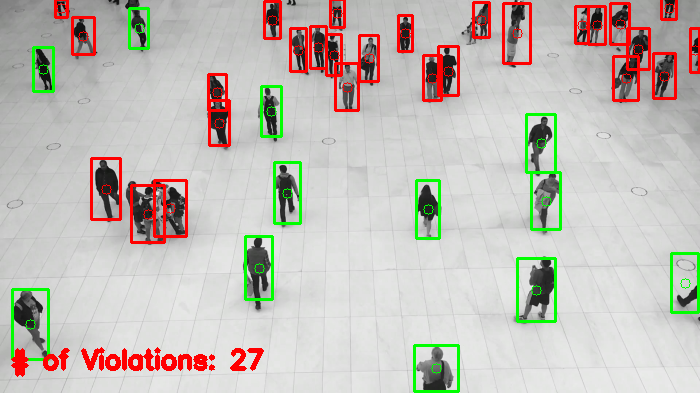

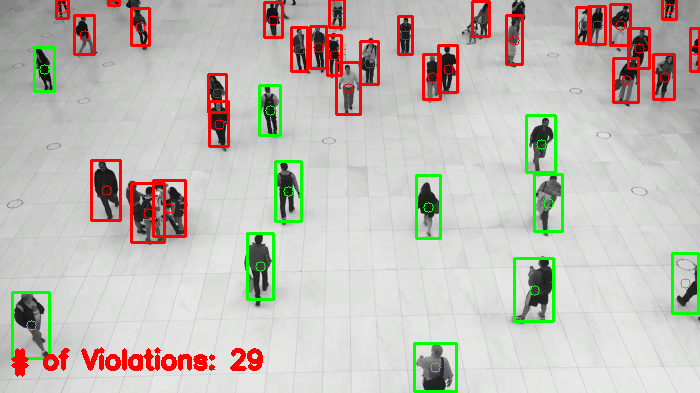

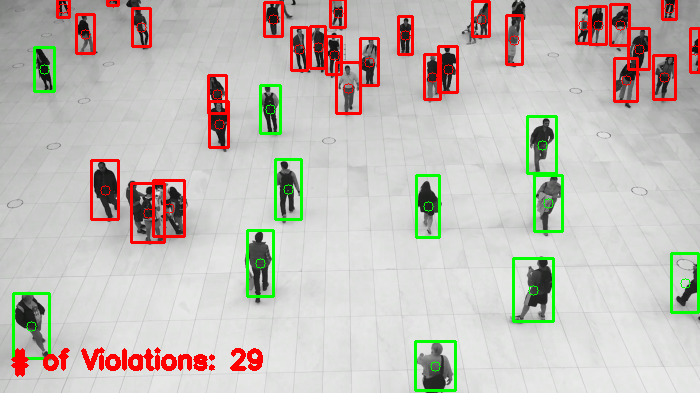

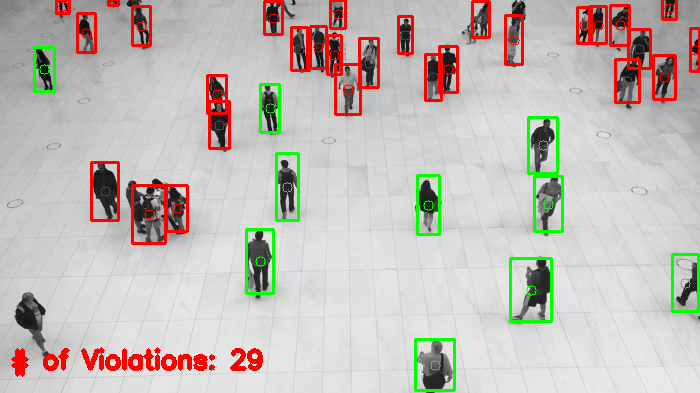

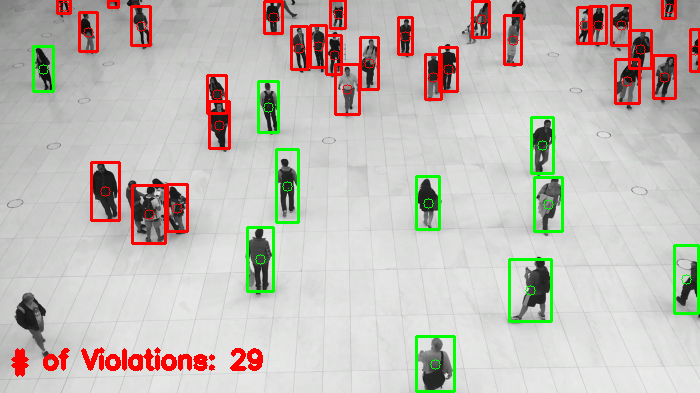

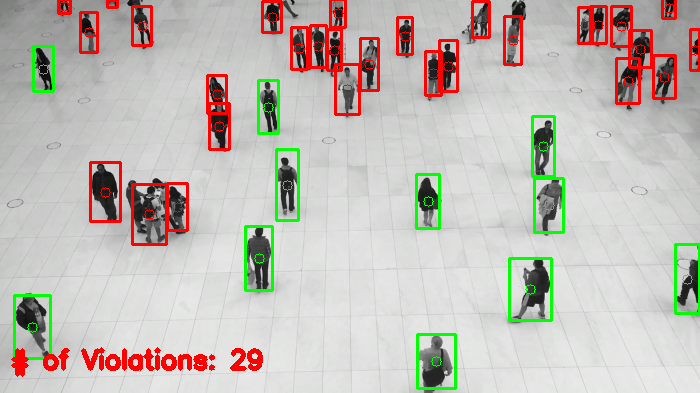

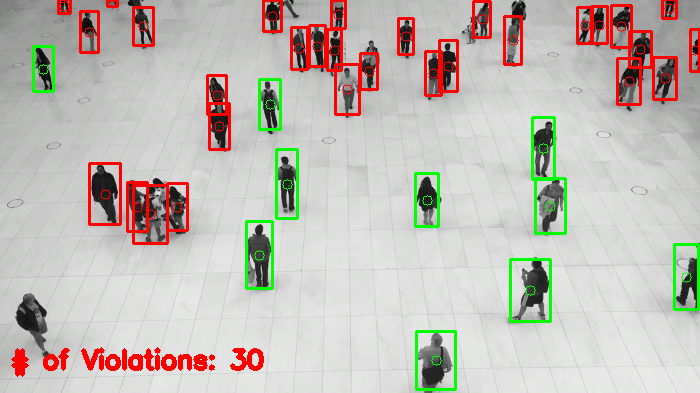

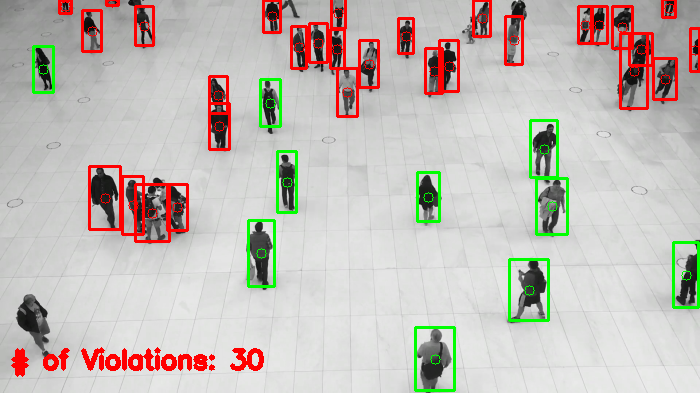

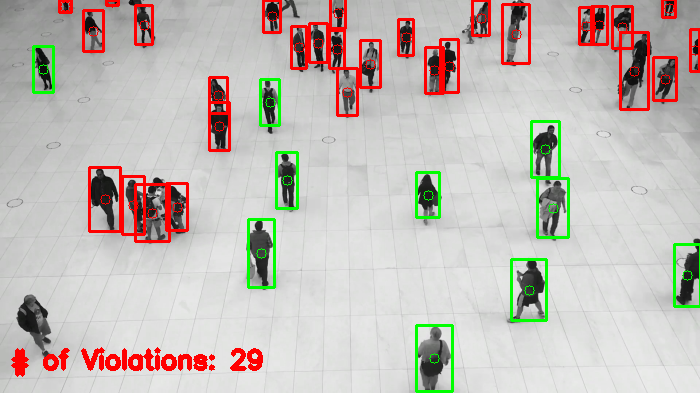

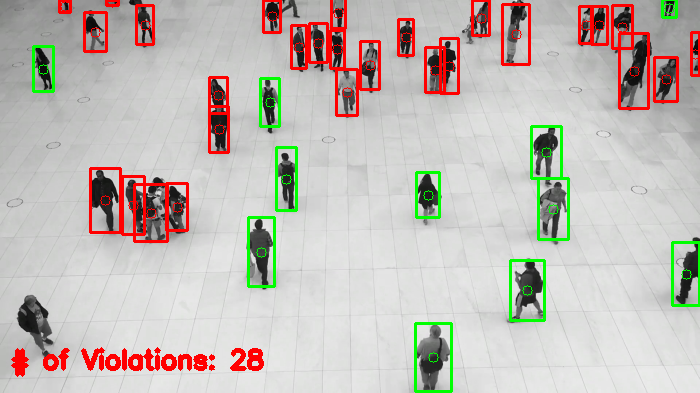

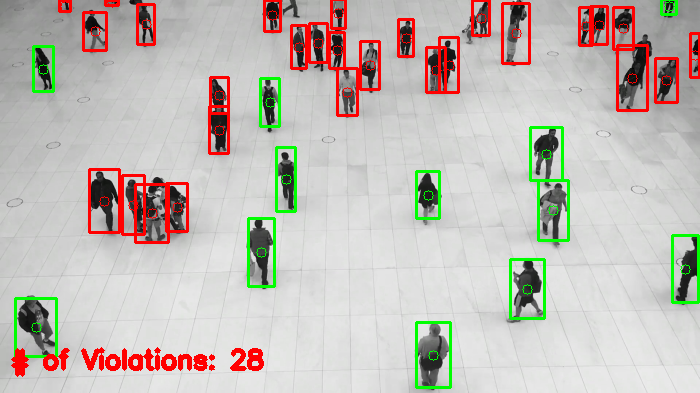

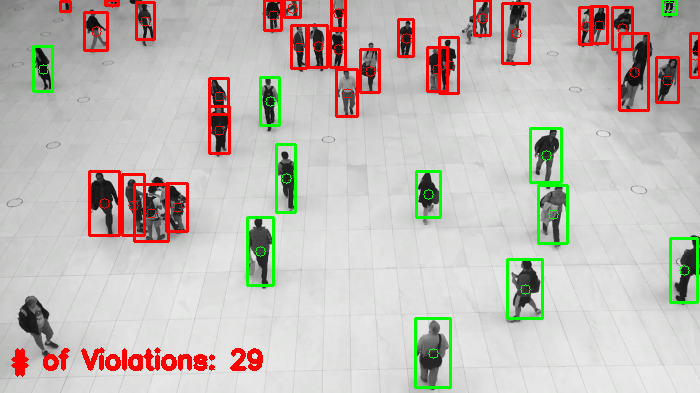

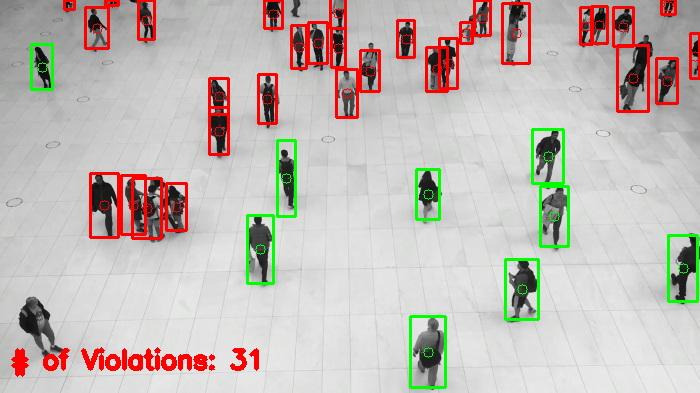

KeyboardInterrupt: ignored

In [ ]:
try:
	lg.info("accessing video stream...")
	vs = cv2.VideoCapture(args["input"] if args["input"] else 0)
	lg.info('initialized the video stream and pointer to output video file')
	writer = None

	prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	lg.info("Total frames in video==>{}".format(total))
  
	# "loop over the frames from the video stream"
	while True:
		# "read the next frame from the file"
		(grabbed, frame) = vs.read()

		# "if the frame was not grabbed, then we have reached the end of the stream"
		if not grabbed:
			break

		# "resize the frame and then detect human in it"
		frame = imutils.resize(frame, width=700)
		results = detect_people(frame, net, ln,	personIdx=LABELS.index("person"))

		# "initialize the set of indexes that violate the minimum social distance"
		violate = set()

		# "ensure there are *at least* two people detections (required in order to compute our pairwise distance maps)"
		if len(results) >= 2:
			# "extract all centroids from the results and compute the Euclidean distances between all pairs of the centroids"
			centroids = np.array([r[2] for r in results])
			D = dist.cdist(centroids, centroids, metric="euclidean")

			# "loop over the upper triangular of the distance matrix"
			for i in range(0, D.shape[0]):
				for j in range(i + 1, D.shape[1]):
					# "check to see if the distance between any two centroid pairs is less than the configured number of pixels"
					if D[i, j] < MIN_DISTANCE:
						# "update our violation set with the indexes of the centroid pairs"
						violate.add(i)
						violate.add(j)

		# "loop over the results"
		for (i, (prob, bbox, centroid)) in enumerate(results):
			# "extract the bounding box and centroid coordinates, then initialize the color of the annotation"
			(startX, startY, endX, endY) = bbox
			(cX, cY) = centroid
			color = (0, 255, 0)

			# "if the index pair exists within the violation set, then update the color"
			if i in violate:
				color = (0, 0, 255)

			# "draw (1) a bounding box around the person and (2) the centroid coordinates of the person,"
			cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
			cv2.circle(frame, (cX, cY), 5, color, 1)

		# draw the total number of social distancing violations on the output frame"
		text = "# of Violations: {}".format(len(violate))
		cv2.putText(frame, text, (10, frame.shape[0] - 25),	cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)

		# "check to see if the output frame should be displayed to our screen"
		if args["display"] > 0:
			# "show the output frame"
			cv2_imshow(frame)
			key = cv2.waitKey(1) & 0xFF

			# "if the `q` key was pressed, break from the loop"
			if key == ord("q"):
				break

		# "if an output video file path has been supplied and the video writer has not been initialized, do so now"
		if args["output"] != "" and writer is None:
			# "initialize our video writer"
			fourcc = cv2.VideoWriter_fourcc(*"MJPG")
			writer = cv2.VideoWriter(args["output"], fourcc, 25,(frame.shape[1], frame.shape[0]), True)

		# "if the video writer is not None, write the frame to the output video file"
		if writer is not None:
			writer.write(frame)
	 
except Exception as E:
	lg.error('something went wrog')
	lg.exception(str(E))
	
finally:
	lg.shutdown()